**For dataset and packages, please use this [project](https://aistudio.baidu.com/aistudio/projectdetail/3572423) rather than this code!**

In [ ]:
! mkdir -p data/tmp
! mkdir -p data/dataset
! cat data/data52359/train.tar.* > data/tmp/train.tar
! tar -xvf data/data52359/val.tar -C data/dataset
! tar -xvf data/tmp/train.tar -C data/dataset

In [ ]:
! pip install -q paddleclas paddle2onnx onnx onnxruntime
# ! wget -P work/ https://paddle-imagenet-models-name.bj.bcebos.com/dygraph/GhostNet_x1_3_ssld_pretrained.pdparams

In [3]:
import os
import os.path as osp


def create_list(train_path, val_path):
    data_path = "data/dataset"
    with open(osp.join(data_path, "train_list.txt"), 'w') as train_f:
        with open(osp.join(data_path, "val_list.txt"), 'w') as val_f:
            with open(osp.join(data_path, "labels.txt"), 'w') as label_f:
                i_classes = os.listdir(train_path)
                i_classes = sorted(i_classes)
                for idx, i_class in enumerate(i_classes):
                    label_f.write(i_class + '\n')
                    train_imgs_path = osp.join(train_path, i_class)
                    train_imgs = os.listdir(train_imgs_path)
                    for name in train_imgs:
                        if name.split(".")[-1] in ["jpe", "jpeg", "png"]:
                            train_f.write(osp.join(train_imgs_path.split('/')[2], i_class, name) + "|" + str(idx) + '\n')
                    val_imgs_path = osp.join(val_path, i_class)
                    val_imgs = os.listdir(val_imgs_path)
                    for name in val_imgs:
                        if name.split(".")[-1] in ["jpe", "jpeg", "png"]:
                            val_f.write(osp.join(val_imgs_path.split('/')[2], i_class, name) + "|" + str(idx) + '\n')
                    
train_path = "data/dataset/train"
val_path = "data/dataset/val"
create_list(train_path, val_path)

In [1]:
import os
import os.path as osp
import random
import cv2
import numpy as np
import paddle
from paddle.io import Dataset
import paddle.vision.transforms as T


class ClsDataset(Dataset):
    def __init__(self, data_folder, data_list_path, labels_path, transforms=None, shuffle=False):
        self.data_folder = data_folder
        self.transforms = T.Compose(transforms) if transforms is not None else None
        with open(data_list_path, "r") as f:
            self.dataset = f.readlines()
        with open(labels_path, "r") as f:
            self.labels = f.readlines()
        self.labels = [label.strip() for label in self.labels]
        self.labels = sorted(self.labels)
        if shuffle:
            random.seed(666)
            random.shuffle(self.dataset)

    def __getitem__(self, idx):
        img_name, lab = self.dataset[idx].strip().split("|")
        img_path = osp.join(self.data_folder, img_name)
        img = cv2.imdecode(np.fromfile(img_path, dtype="uint8"), -1)  # cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype("uint8")
        if self.transforms is not None:
            img = self.transforms(img)
        return img.astype("float32"), paddle.to_tensor(int(lab), dtype="int64")
    
    def __len__(self):
        return len(self.dataset)


train_dataset = ClsDataset(
    data_folder="data/dataset",
    data_list_path="data/dataset/train_list.txt",
    labels_path="data/dataset/labels.txt",
    transforms=[
        T.RandomHorizontalFlip(),
        T.RandomVerticalFlip(),
        T.RandomRotation(15),
        T.Resize((128, 128)),
        T.ToTensor(),
        T.Normalize()
    ],
    shuffle=True
)

val_dataset = ClsDataset(
    data_folder="data/dataset",
    data_list_path="data/dataset/val_list.txt",
    labels_path="data/dataset/labels.txt",
    transforms=[
        T.Resize((128, 128)),
        T.ToTensor(),
        T.Normalize()
    ]
)

In [ ]:
from paddleclas.ppcls.arch.backbone.model_zoo.ghostnet import GhostNet_x1_3


num_classes = len(train_dataset.labels)
model = GhostNet_x1_3(class_num=num_classes)
model.set_state_dict(paddle.load("work/GhostNet_x1_3_ssld_pretrained.pdparams"))

In [3]:
from math import ceil
from paddle.optimizer import Momentum
from paddle.optimizer.lr import CosineAnnealingDecay
from paddle.regularizer import L2Decay
from paddle.nn import CrossEntropyLoss
from paddle.metric import Accuracy


epoch = 20
batch_size = 128
step_each_epoch = ceil(len(train_dataset) / batch_size)
base_lr = 3e-4
lr = CosineAnnealingDecay(learning_rate=base_lr, T_max=step_each_epoch * epoch)
opt = Momentum(learning_rate=lr,
               momentum=0.9,
               weight_decay=L2Decay(0.0001),
               parameters=model.parameters())

net = paddle.Model(model)
net.prepare(opt, CrossEntropyLoss(), Accuracy(topk=(1, 5)))

In [ ]:
net.fit(train_dataset,
        val_dataset,
        epochs=epoch,
        batch_size=batch_size,
        verbose=1)

net.save("output/GhostNet_x1_3", training=True)

In [ ]:
net.load("output/GhostNet_x1_3.pdparams")
_ = net.evaluate(val_dataset, batch_size=64, verbose=1)

In [ ]:
import paddle
from paddle.static import InputSpec
from paddleclas.ppcls.arch.backbone.model_zoo.ghostnet import GhostNet_x1_3


ghostnet = GhostNet_x1_3(class_num=46)
ghostnet.set_state_dict(paddle.load("output/GhostNet_x1_3.pdparams"))
ghostnet.eval()
x_spec = InputSpec([None, 3, 128, 128], "float32", "x")
paddle.onnx.export(ghostnet, "output/GhostNet_x1_3", input_spec=[x_spec])

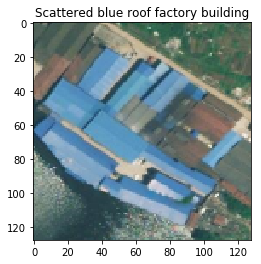

In [24]:
import cv2
import numpy as np
import onnxruntime
import matplotlib.pyplot as plt

%matplotlib inline


# img
img = cv2.cvtColor(cv2.imread("data/dataset/val/Scattered blue roof factory building/ScreenShot06053.png"), cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (128, 128))  # resize
x = (img / 255.0).astype("float32")  # normalize
x = x.transpose((2, 0, 1))[np.newaxis, :]  # totensor
# labels
with open("data/dataset/labels.txt", "r") as f:
    label_map = f.readlines()
label_map = [label.strip() for label in label_map]
label_map = sorted(label_map)
# infer
ort_sess = onnxruntime.InferenceSession("output/GhostNet_x1_3.onnx")
ort_inputs = {ort_sess.get_inputs()[0].name: x}
ort_outs = ort_sess.run(None, ort_inputs)[0]
idx = int(np.argmax(ort_outs, axis=-1)[0])
infer_lab = label_map[idx]
# display
plt.imshow(img);plt.title(infer_lab)
plt.show()